In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import beta

from sklearn.base import clone
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
from sklearn.inspection import DecisionBoundaryDisplay



import os
import sys
sys.path.append(os.path.join(os.path.abspath(''), '..'))
from utils.transformer import WaveletTransformer
from utils.kernels import generalized_cone_kernel

In [23]:
X = np.load('../data/X_regular_reduced.npy')
y = np.load('../data/y_regular_reduced.npy')
groups = np.load('../data/groups_regular_reduced.npy')
severities = np.load('../data/severities_regular_reduced.npy')

In [24]:
X_train, X_test, y_train, y_test, groups_train, groups_test = train_test_split(X, y, groups, test_size=0.5, random_state=1)

def create_kernel(gamma, beta):
    def kernel(X, Y):
        return generalized_cone_kernel(X, Y, gamma, beta)
    return kernel

pipeline = Pipeline([
    ('wavelet_transformer', WaveletTransformer(w_list=[125, 3448], n_samples=100, n_frequencies=20)),
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=90)),
    ('svm', SVC(probability=True, kernel=create_kernel(0.8947, 895.7), C=31.5))
])

In [25]:
X_train, X_test, y_train, y_test, groups_train, groups_test = train_test_split(X, y, groups, test_size=0.5, random_state=1)
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)
y_pred_proba = pipeline.predict_proba(X_test)

Accuracy: 87.06%
AUC ROC: 0.93


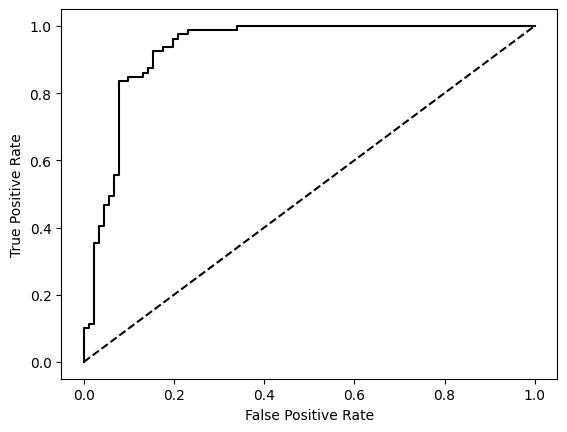

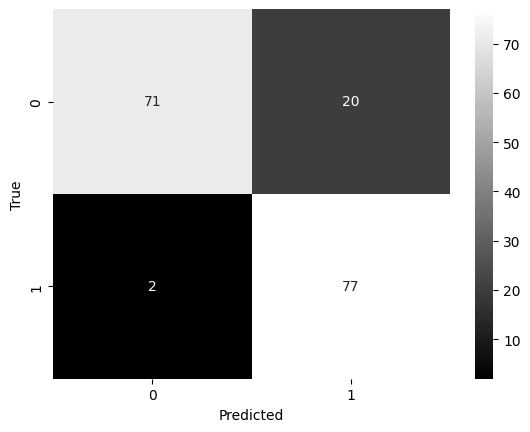

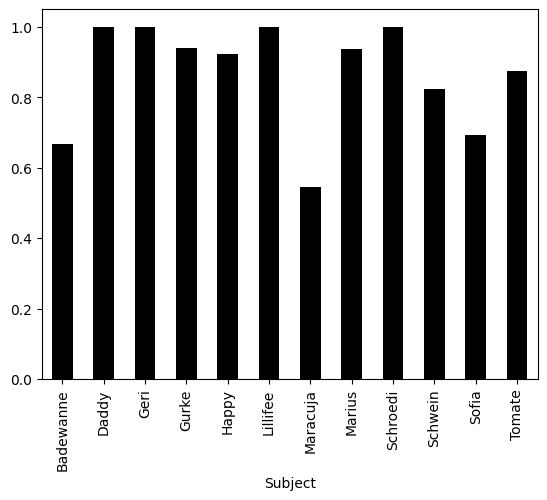

In [26]:
accuracy = np.mean(y_pred == y_test)
print(f'Accuracy: {accuracy:.2%}')

auc_roc = roc_auc_score(y_test, y_pred_proba[:, 1])
print(f'AUC ROC: {auc_roc:.2f}')

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:, 1])
plt.plot(fpr, tpr, color='black')
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, cmap='grey')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

df = pd.DataFrame({'y': y_test, 'y_pred': y_pred, 'Subject': groups_test})
df['correct'] = df['y'] == df['y_pred']
df.groupby('Subject').mean()['correct'].plot(kind='bar', color='black');

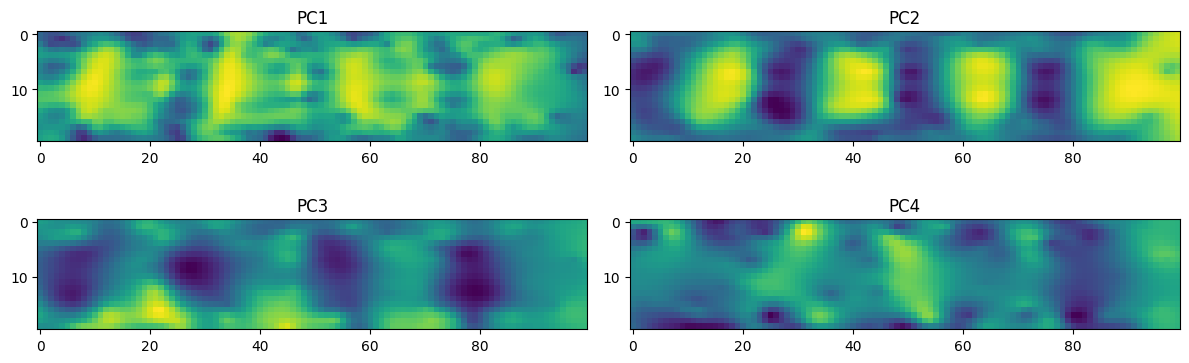

In [27]:
pca = pipeline.named_steps['pca']

num_plots = min(len(pca.components_), 4)
num_cols = 2
num_rows = (num_plots + 1)//num_cols
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(6*num_cols, 2*num_rows))

for row in range(num_rows):
    for col in range(num_cols):
        idx = row*num_cols + col
        if idx >= num_plots:
            break
        pc = pca.components_[idx]
        pc = np.moveaxis(pc.reshape(-1, 20, 100), 0, -1)
        axes[row, col].imshow(pc[:,:,0])
        axes[row, col].set_title('PC' + str(idx + 1))
fig.tight_layout()
plt.show()

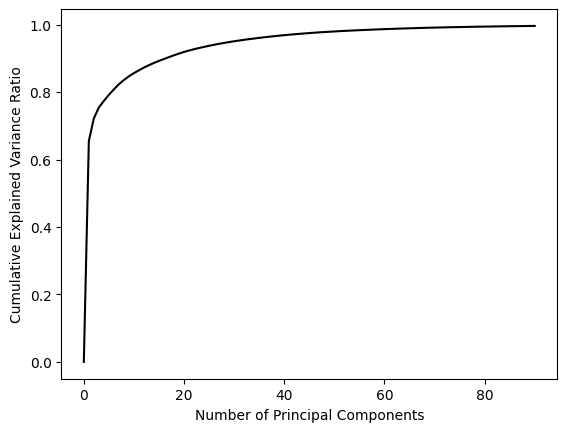

In [28]:
cumulative_explained_variance_ratio = np.concatenate((np.zeros(1), pca.explained_variance_ratio_)).cumsum()
num_components = len(cumulative_explained_variance_ratio)
plt.plot(range(0, num_components), cumulative_explained_variance_ratio, color='black')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.show()

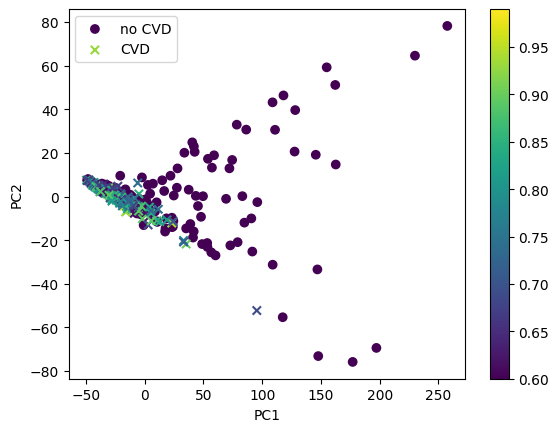

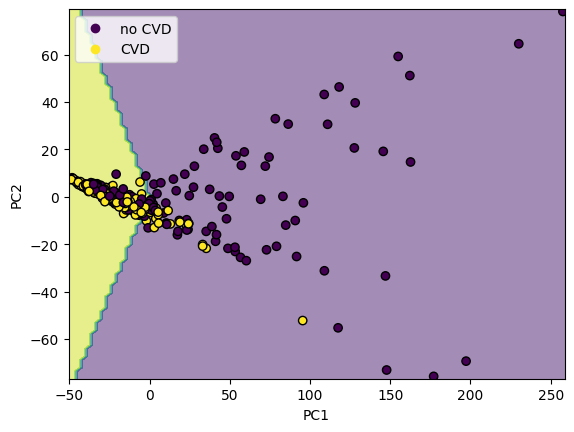

In [29]:
X_pca = pipeline.named_steps['wavelet_transformer'].transform(X)
X_pca = pipeline.named_steps['scaler'].transform(X_pca)
X_pca = pipeline.named_steps['pca'].transform(X_pca)

markers = ['o', 'x']
for i, marker in enumerate(markers):
    plt.scatter(X_pca[y == i, 0], X_pca[y == i, 1], marker=marker, label='CVD' if i == 1 else 'no CVD', c=np.array(severities)[y == i])

plt.legend()
plt.colorbar()
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

X_reduced = X_pca[:,:2]

model = clone(pipeline.named_steps['svm'])

model.fit(X_reduced, y)
disp = DecisionBoundaryDisplay.from_estimator(
    model, X_reduced, response_method="predict",
    xlabel='PC1', ylabel='PC2',
    alpha=0.5,
)
scatter = disp.ax_.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, edgecolors='k', cmap='viridis')
disp.ax_.legend(handles=scatter.legend_elements()[0], labels=['no CVD', 'CVD'])
plt.show()

In [30]:
X_cvd = np.load('../data/X_cvd_reduced.npy')
y_cvd = np.load('../data/y_cvd_reduced.npy')
groups_cvd = np.load('../data/groups_cvd_reduced.npy')
severities_cvd = np.load('../data/severities_cvd_reduced.npy')

In [31]:
y_pred_cvd = pipeline.predict(X_cvd)

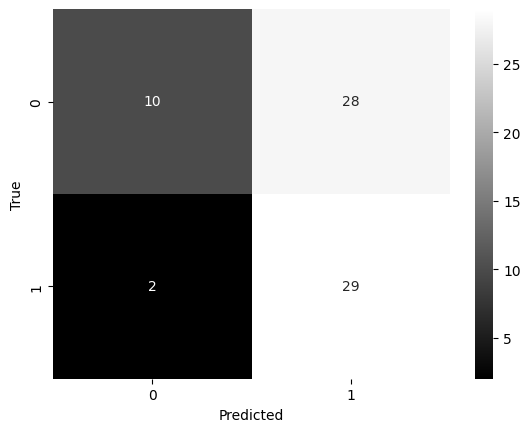

In [32]:
conf_matrix = confusion_matrix(y_cvd, y_pred_cvd)
sns.heatmap(conf_matrix, annot=True, cmap='grey')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [33]:
y_pred_proba_cvd = pipeline.predict_proba(X_cvd)

No CVD No Sim
a: 0.44, b: 0.71


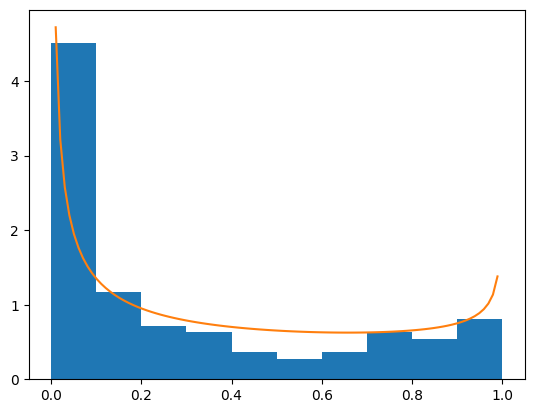

No CVD Sim
a: 1.06, b: 0.42


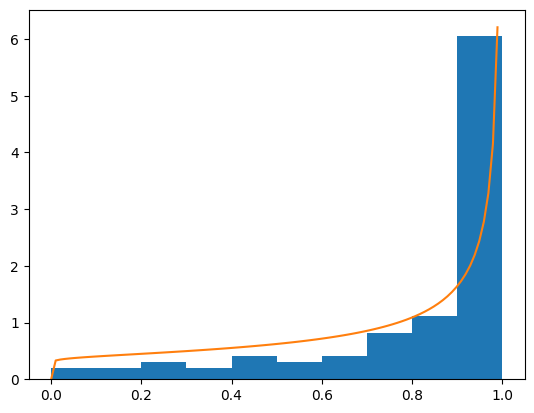

CVD Sim


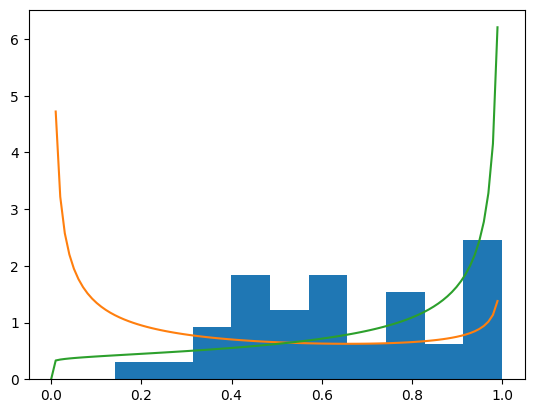

In [36]:
no_cvd_no_sim = y_pred_proba[y_test == 0][:, 1]
no_cvd_sim = y_pred_proba[y_test == 1][:, 1]

no_cvd_no_sim = np.concatenate((no_cvd_no_sim, np.linspace(0, 1, 20)))
no_cvd_sim = np.concatenate((no_cvd_sim, np.linspace(0, 1, 20)))

mu_no_cvd = np.mean(no_cvd_no_sim)
sigma_no_cvd = np.std(no_cvd_no_sim)
a_no_cvd = mu_no_cvd*(mu_no_cvd*(1-mu_no_cvd)/sigma_no_cvd**2 - 1)
b_no_cvd = (1-mu_no_cvd)*(mu_no_cvd*(1-mu_no_cvd)/sigma_no_cvd**2 - 1)

mu_cvd = np.mean(no_cvd_sim)
sigma_cvd = np.std(no_cvd_sim)
a_cvd = mu_cvd*(mu_cvd*(1-mu_cvd)/sigma_cvd**2 - 1)
b_cvd = (1-mu_cvd)*(mu_cvd*(1-mu_cvd)/sigma_cvd**2 - 1)

regularization_strength = 0.25
a_no_cvd += regularization_strength * (1 - a_no_cvd)
b_no_cvd += regularization_strength * (1 - b_no_cvd)
a_cvd += regularization_strength * (1 - a_cvd)
b_cvd += regularization_strength * (1 - b_cvd)

print('No CVD No Sim')
print(f'a: {a_no_cvd:.2f}, b: {b_no_cvd:.2f}')
plt.hist(no_cvd_no_sim, density=True)
plt.plot(np.linspace(0, 1, 100), beta.pdf(np.linspace(0, 1, 100), a_no_cvd, b_no_cvd))
plt.show()

print('No CVD Sim')
print(f'a: {a_cvd:.2f}, b: {b_cvd:.2f}')
plt.hist(no_cvd_sim, density=True)
plt.plot(np.linspace(0, 1, 100), beta.pdf(np.linspace(0, 1, 100), a_cvd, b_cvd))
plt.show()

print('CVD Sim')
plt.hist(y_pred_proba_cvd[y_cvd == 0][:, 1], density=True)
plt.plot(np.linspace(0, 1, 100), beta.pdf(np.linspace(0, 1, 100), a_no_cvd, b_no_cvd))
plt.plot(np.linspace(0, 1, 100), beta.pdf(np.linspace(0, 1, 100), a_cvd, b_cvd))
plt.show()

Subject: Schwein, Accuracy: 71.43%
Log Likelihood No CVD: 4.22233816355356
Log Likelihood CVD: -2.800597771934851
No CVD


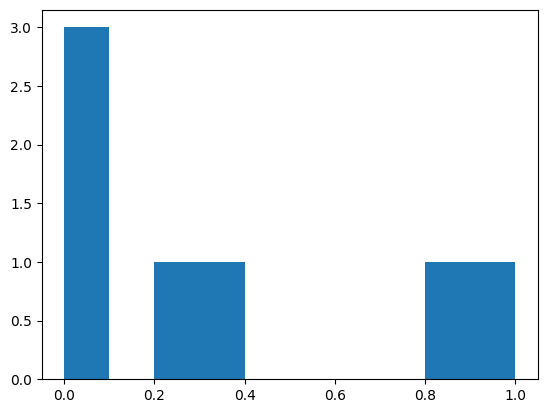

Subject: Gurke, Accuracy: 90.91%
Log Likelihood No CVD: 5.839773907119108
Log Likelihood CVD: -9.371083417533407
No CVD


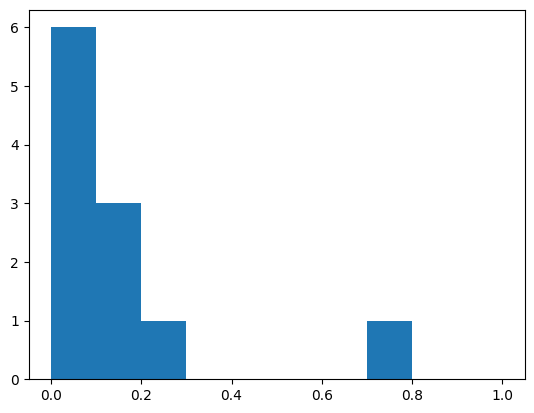

Subject: Geri, Accuracy: 100.00%
Log Likelihood No CVD: 22.73138500910437
Log Likelihood CVD: -12.643614637689367
No CVD


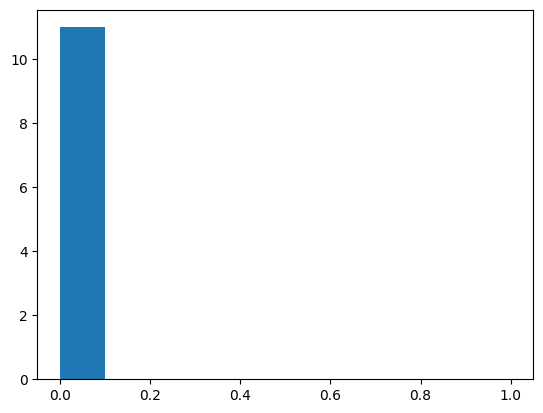

Subject: Badewanne, Accuracy: 28.57%
Log Likelihood No CVD: 2.2837103525745466
Log Likelihood CVD: 5.717765237754384
CVD


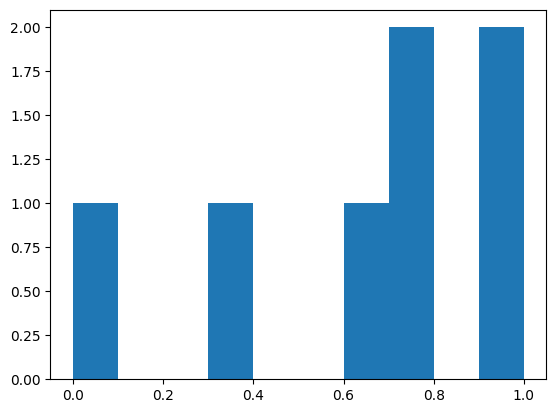

Subject: Lillifee, Accuracy: 100.00%
Log Likelihood No CVD: 4.0380481411921405
Log Likelihood CVD: -4.974722664691211
No CVD


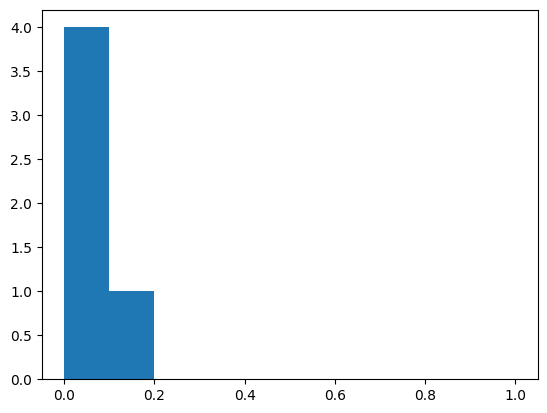

Subject: Happy, Accuracy: 83.33%
Log Likelihood No CVD: 5.25048097425687
Log Likelihood CVD: -4.198124761342351
No CVD


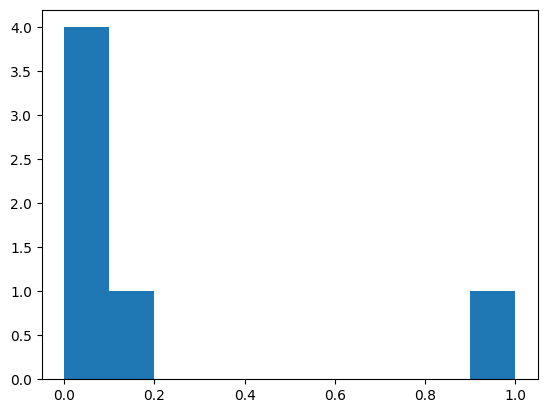

Subject: Maracuja, Accuracy: 16.67%
Log Likelihood No CVD: -1.4888710708402668
Log Likelihood CVD: -0.07351502124770182
CVD


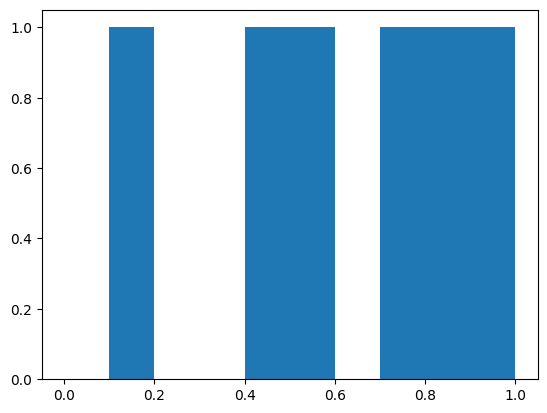

Subject: Tomate, Accuracy: 77.78%
Log Likelihood No CVD: 11.735503284636822
Log Likelihood CVD: -7.711317029748365
No CVD


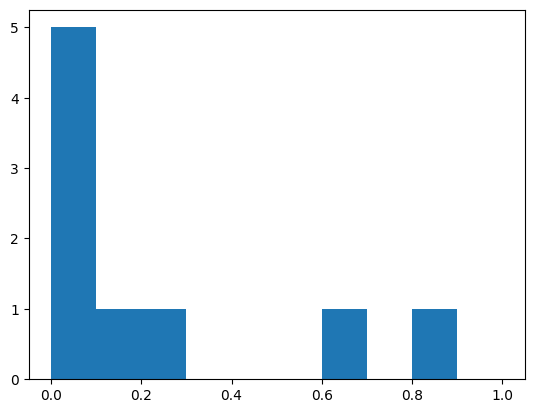

Subject: Marius, Accuracy: 85.71%
Log Likelihood No CVD: 6.046425682806927
Log Likelihood CVD: -5.969212309561192
No CVD


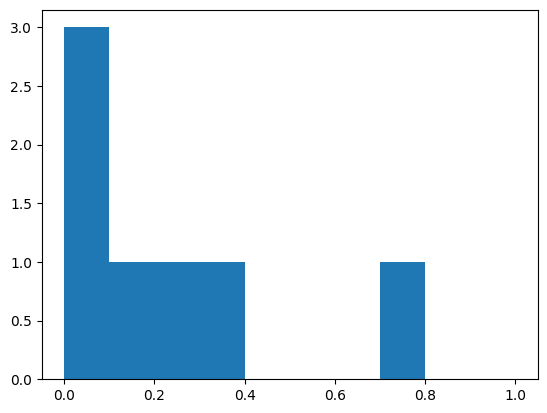

Subject: Daddy, Accuracy: 100.00%
Log Likelihood No CVD: 9.604734500267739
Log Likelihood CVD: -8.629093215748043
No CVD


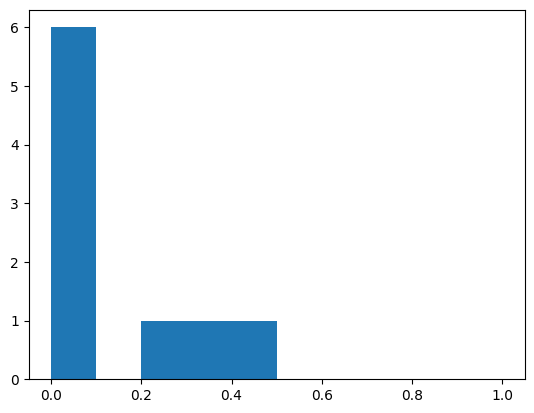

Subject: Sofia, Accuracy: 62.50%
Log Likelihood No CVD: 2.973966055000769
Log Likelihood CVD: 3.86592543285849
CVD


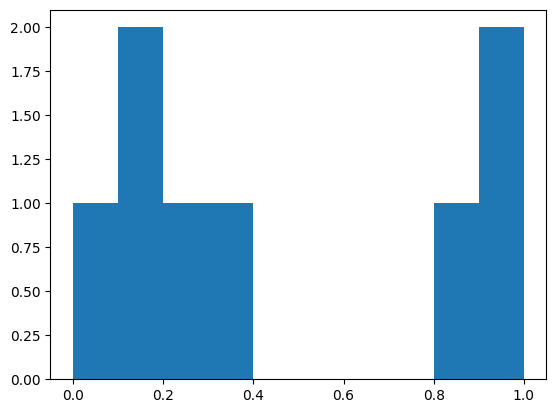

Subject: Schroedi, Accuracy: 100.00%
Log Likelihood No CVD: 4.729734755590941
Log Likelihood CVD: -5.08875517096075
No CVD


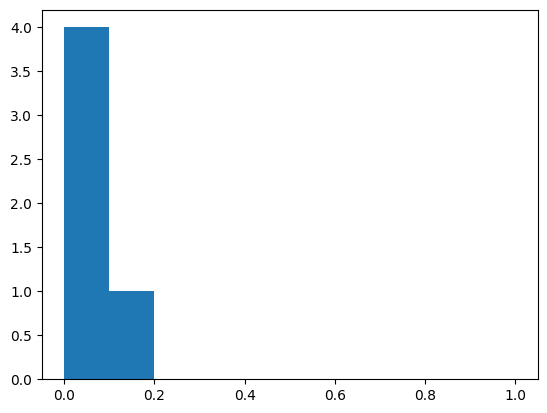

Subject: Fisch, Accuracy: 10.00%
Log Likelihood No CVD: 15.669906798666947
Log Likelihood CVD: 41.84914287576362
CVD


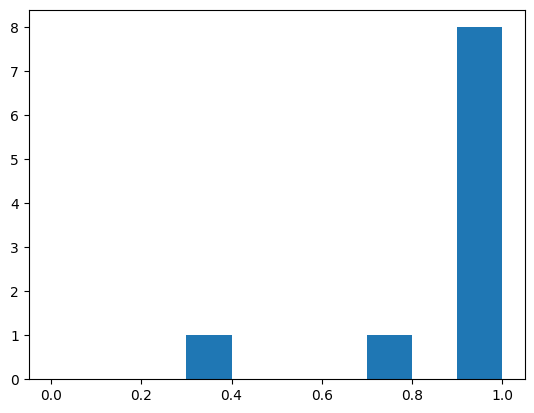

Subject: Wert, Accuracy: 33.33%
Log Likelihood No CVD: -4.9731280904635105
Log Likelihood CVD: -3.4265790583333313
CVD


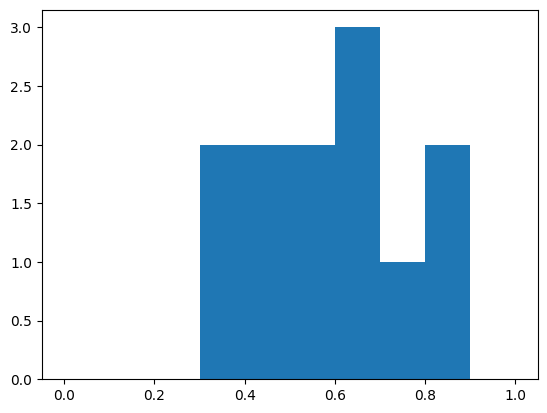

Subject: Jens, Accuracy: 31.25%
Log Likelihood No CVD: -6.062456725398219
Log Likelihood CVD: -5.828449929129061
CVD


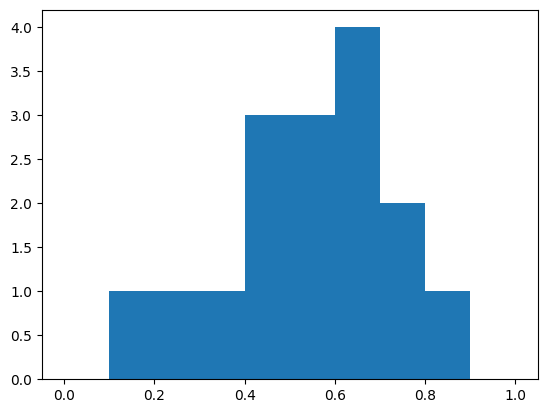

In [37]:
for group in set(groups_test):
    y_group_pred = y_pred[np.logical_and(groups_test == group, y_test == 0)]
    y_group_pred_proba = y_pred_proba[np.logical_and(groups_test == group, y_test == 0)]
    print(f'Subject: {group}, Accuracy: {np.mean(y_group_pred == 0):.2%}')
    log_likelihood_no_cvd = np.sum(beta.logpdf(y_group_pred_proba[:, 1], a_no_cvd, b_no_cvd))
    log_likelihood_cvd = np.sum(beta.logpdf(y_group_pred_proba[:, 1], a_cvd, b_cvd))
    print(f'Log Likelihood No CVD: {log_likelihood_no_cvd}')
    print(f'Log Likelihood CVD: {log_likelihood_cvd}')
    if log_likelihood_no_cvd > log_likelihood_cvd:
        print('No CVD')
    else:
        print('CVD')
        
    plt.hist(y_group_pred_proba[:, 1], range=(0, 1))
    plt.show()

for group in set(groups_cvd):
    y_group_pred = y_pred_cvd[np.logical_and(groups_cvd == group, y_cvd == 0)]
    y_group_pred_proba = y_pred_proba_cvd[np.logical_and(groups_cvd == group, y_cvd == 0)]
    print(f'Subject: {group}, Accuracy: {np.mean(y_group_pred == 0):.2%}')
    log_likelihood_no_cvd = np.sum(beta.logpdf(y_group_pred_proba[:, 1], a_no_cvd, b_no_cvd))
    log_likelihood_cvd = np.sum(beta.logpdf(y_group_pred_proba[:, 1], a_cvd, b_cvd))
    print(f'Log Likelihood No CVD: {log_likelihood_no_cvd}')
    print(f'Log Likelihood CVD: {log_likelihood_cvd}')
    if log_likelihood_no_cvd > log_likelihood_cvd:
        print('No CVD')
    else:
        print('CVD')
        
    plt.hist(y_group_pred_proba[:, 1], range=(0, 1))
    plt.show()